Moneyness Ratio Summary:
count    4.000000e+06
mean     8.448132e-01
std      8.352704e-01
min      5.728112e-02
25%      3.400050e-01
50%      5.788422e-01
75%      1.002284e+00
max      6.661873e+00
Name: MoneynessRatio, dtype: float64

Moneyness Percentage Summary:
count    4.000000e+06
mean    -1.551868e+01
std      8.352704e+01
min     -9.427189e+01
25%     -6.599950e+01
50%     -4.211578e+01
75%      2.283549e-01
max      5.661873e+02
Name: MoneynessPercentage, dtype: float64


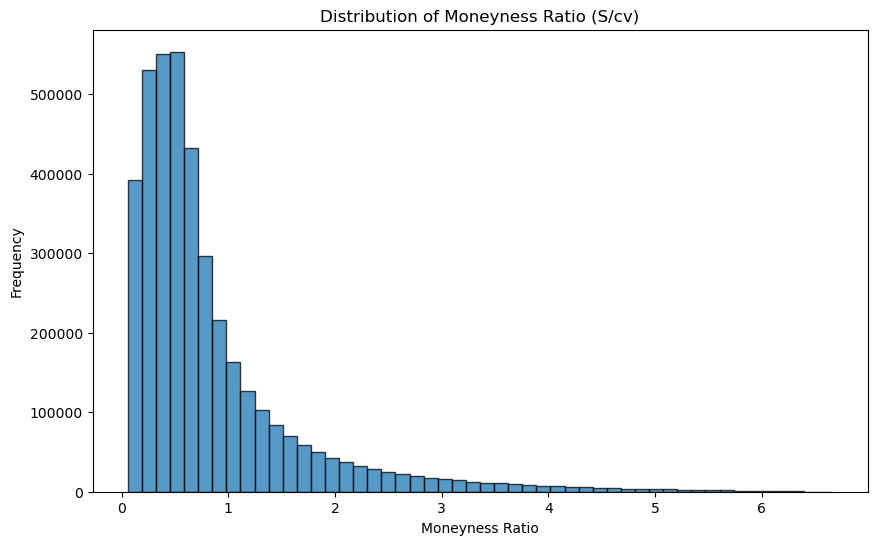

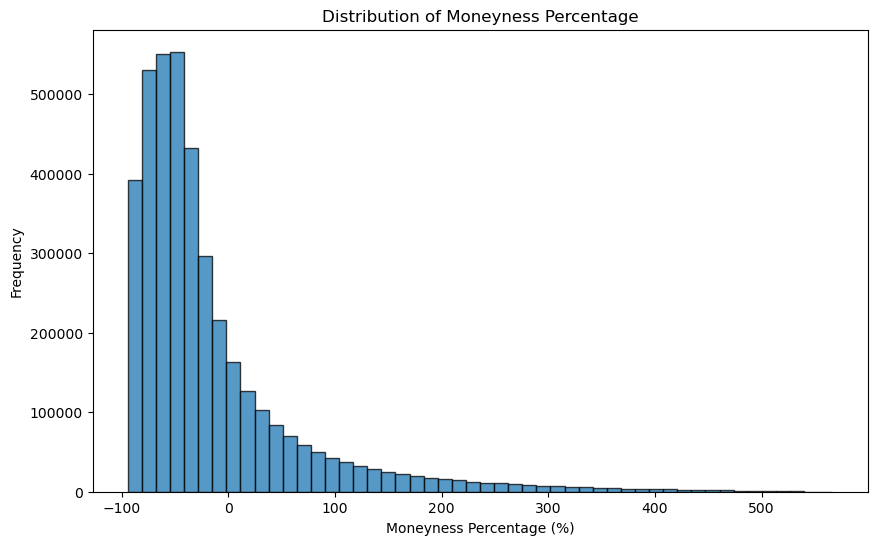

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("/Users/calvinxiang/Downloads/4M.csv")
df['MoneynessRatio'] = df['S'] / df['cv']
df['MoneynessPercentage'] = (df['S'] - df['cv']) / df['cv'] * 100
print("Moneyness Ratio Summary:")
print(df['MoneynessRatio'].describe())
print("\nMoneyness Percentage Summary:")
print(df['MoneynessPercentage'].describe())
plt.figure(figsize=(10, 6))
plt.hist(df['MoneynessRatio'].dropna(), bins=50, edgecolor='k', alpha=0.75)
plt.title("Distribution of Moneyness Ratio (S/cv)")
plt.xlabel("Moneyness Ratio")
plt.ylabel("Frequency")
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(df['MoneynessPercentage'].dropna(), bins=50, edgecolor='k', alpha=0.75)
plt.title("Distribution of Moneyness Percentage")
plt.xlabel("Moneyness Percentage (%)")
plt.ylabel("Frequency")
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/Users/calvinxiang/Downloads/synthetic_4M_total.csv")

# Compute moneyness measures
df['MoneynessRatio'] = df['S'] / df['cv']
df['MoneynessPercentage'] = (df['S'] - df['cv']) / df['cv'] * 100

# Define thresholds for moneyness categorization.
# (These thresholds are examples – adjust as necessary for your application.)
def moneyness_category(ratio):
    if ratio < 0.8:
        return "Deep OTM"
    elif ratio < 0.95:
        return "OTM"
    elif ratio <= 1.05:
        return "ATM"
    elif ratio < 1.2:
        return "ITM"
    else:
        return "Deep ITM"

# Apply the categorization to create a new column.
df['MoneynessCategory'] = df['MoneynessRatio'].apply(moneyness_category)

# Print summary counts for each category.
print("Moneyness Category Counts:")
print(df['MoneynessCategory'].value_counts())

# Plot a bar chart for the distribution of moneyness categories.
counts = df['MoneynessCategory'].value_counts()
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', edgecolor='k', color='skyblue')
plt.title("Distribution of Moneyness Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/calvinxiang/Downloads/synthetic_4M_total.csv'

In [4]:
print(df.head())

          T  ttm_days          Pr       IVOL         CDS          S        cp  \
0  1.463014       534  107.643363  20.199335  303.057822  57.545810  0.021372   
1  4.608219      1682   58.262758  29.336758  274.972968  17.375241  0.039609   
2  9.246575      3375  139.583291  23.213115  102.343143  24.566003  0.052615   
3  5.783562      2111  145.057182  29.986205  145.771531  38.505855  0.059322   
4  2.035616       743   94.542294   9.490034   53.306811  51.466587  0.037737   

   cfq          cv         d         r       tfc  Estimated_Price  \
0    2   24.472515  0.000000  0.013066  0.011111       246.160938   
1    4   74.151804  0.121227  0.034485  0.022222        68.819234   
2    2   55.032560  0.156892  0.046039  0.116667       183.523346   
3    2  150.639175  0.000000  0.038581  0.011111       187.279109   
4    2   67.354336  0.049369  0.029036  0.033333       101.284906   

   MoneynessRatio  MoneynessPercentage MoneynessCategory  
0        2.351447           135.144654 

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit

# ------------------------- Part 1: LOAD DATA -------------------------
df = pd.read_csv("/Users/calvinxiang/Downloads/4M.csv")
df = df.rename(columns={
    "bond_price": "Pr",
    "BestIVOL": "IVOL",
    "stock_price": "S",
    "CDS": "CDS",
    "coupon_rate": "cp",
    "coupon_frequency": "cfq",
    "conversion_price": "cv",
    "dividend": "d",
    "interest_rate": "r"
})
df["T"] = df["ttm_days"] / 365.0
df["MoneynessRatio"] = df["S"] / df["cv"]

# --------------------- Part 2: PICK DEEP-OTM ROW ---------------------
deep_otm = df[df["MoneynessRatio"] < 0.8]
selected = deep_otm.iloc[0]
bond_data = dict(
    Pr=float(selected["Pr"]),
    T=float(selected["T"]),
    sigma=float(selected["IVOL"])/100.0,
    r=float(selected["r"]),
    d=float(selected["d"]),
    rc=float(selected["CDS"])/1e4,
    cv=float(selected["cv"]),
    cp=float(selected["cp"]),
    cfq=int(selected["cfq"]),
    tfc=float(selected["tfc"]),
    S=float(selected["S"])
)



In [ ]:
# ---------------- Part 3: EXACT PRICE BY HALVING dx, dt --------------
@jit(nopython=True)
def block_thomas_solve(A_sub, A_diag, A_sup, b_vec):
    n_int = A_diag.shape[0]
    for i in range(n_int - 1):
        diag_inv = np.linalg.inv(A_diag[i])
        M_i = A_sub[i+1].dot(diag_inv)
        A_diag[i+1] -= M_i.dot(A_sup[i])
        b_vec[i+1] -= M_i.dot(b_vec[i])
    diag_inv = np.linalg.inv(A_diag[n_int - 1])
    X = np.zeros((n_int, 2))
    X[n_int - 1] = diag_inv.dot(b_vec[n_int - 1])
    for i in range(n_int - 2, -1, -1):
        tmp = b_vec[i] - A_sup[i].dot(X[i+1])
        diag_inv = np.linalg.inv(A_diag[i])
        X[i] = diag_inv.dot(tmp)
    return X

@jit(nopython=True)
def crank_nicolson_one_price_block(Pr, T, sigma, r, d, rc, cv, cp, cfq, tfc, S_target, dx, dt,):
    S_max = 2*cv
    M = max(1, int(math.log(S_max)/dx))
    N = max(1, int(T/dt))
    dx_ = math.log(S_max)/M
    dt_ = T/N
    Uo = np.zeros(M+1)
    Vo = np.zeros(M+1)
    Un = np.zeros(M+1)
    Vn = np.zeros(M+1)
    cp_period = 0
    if cfq*T>0: cp_period = int(N/(cfq*T))
    cp_offset = int(tfc*cp_period) if cp_period>0 else 0
    cp_array = np.arange(cp_period+cp_offset, N+1, cp_period, dtype=np.int64) if cp_period>0 else np.empty(0, np.int64)
    cpt = Pr*cp/cfq
    for i in range(1, M):
        si = math.exp(i*dx_)
        if si>=cv:
            Uo[i], Vo[i] = (Pr*si/cv + cpt), 0
        else:
            Uo[i], Vo[i] = 0, Pr
    Uo[0], Vo[0] = 0.0, Pr
    Uo[M], Vo[M] = Pr*math.exp(M*dx_)/cv+cpt, 0
    D = sigma*sigma/2.
    drift = r-d-sigma*sigma/2.
    ac = D/(dx_**2)-drift/(2*dx_)
    cc = D/(dx_**2)+drift/(2*dx_)
    bu = -2*D/(dx_**2)-r
    bv = -2*D/(dx_**2)-(r+rc)
    hh = dt_/2.
    db = np.array([[1-hh*bu, -hh*r],[0,1-hh*bv]])
    lb = np.array([[-hh*ac,0],[0,-hh*ac]])
    ub = np.array([[-hh*cc,0],[0,-hh*cc]])
    db_r = np.array([[1+hh*bu, hh*r],[0,1+hh*bv]])
    lb_r = np.array([[hh*ac,0],[0,hh*ac]])
    ub_r = np.array([[hh*cc,0],[0,hh*cc]])
    n_int = M-1
    X = np.zeros((n_int,2))
    for i in range(n_int):
        idx = i+1
        X[i,0] = Uo[idx]
        X[i,1] = Vo[idx]
    for n_ in range(N-1,-1,-1):
        As = np.zeros((n_int,2,2))
        Ad = np.zeros((n_int,2,2))
        Au = np.zeros((n_int,2,2))
        Bb = np.zeros((n_int,2))
        for i in range(n_int):
            Ad[i] = db.copy()
            if i>0:  As[i] = lb.copy()
            if i<n_int-1:  Au[i] = ub.copy()
        for i in range(n_int):
            tmp = db_r.dot(X[i])
            if i>0:       tmp += lb_r.dot(X[i-1])
            if i<n_int-1: tmp += ub_r.dot(X[i+1])
            Bb[i] = tmp
        left_bc = np.array([Uo[0],Vo[0]])
        Bb[0] -= lb_r.dot(left_bc)
        right_bc = np.array([Uo[M],Vo[M]])
        Bb[n_int-1] -= ub_r.dot(right_bc)
        ft = 0.
        for k_ in cp_array:
            if n_<=k_<n_+1:
                ft = Pr*cp/cfq
                break
        for i in range(n_int):
            Bb[i,1] += ft
        X_ = block_thomas_solve(As,Ad,Au,Bb)
        for i in range(n_int):
            idx = i+1
            Uo[idx] = X_[i,0]
            Vo[idx] = X_[i,1]
        dis = (1+(r+rc)*dt_)**(N-n_)
        Uo[0],Vo[0] = 0.0,Pr/dis
        Uo[M],Vo[M] = Pr*math.exp(M*dx_)/cv,0
    idx = min(M,max(0,int(round(math.log(S_target)/dx_))))
    return Uo[idx]

def price_once(dx,dt,b):
    return crank_nicolson_one_price_block(
        b["Pr"],b["T"],b["sigma"],b["r"],b["d"],b["rc"],b["cv"],
        b["cp"],b["cfq"],b["tfc"],b["S"],dx,dt,S_max=2.*b["cv"]
    )

tol = 1e-8
dx0, dt0 = 0.1, 0.1
price_list = []
for k in range(7):
    print("current iteration:",k)
    p_new = price_once(dx0,dt0,bond_data)
    print("value at iteration",k,'=',p_new,'\n')
    price_list.append((dx0, dt0, p_new))
    if k>0:
        p_old = price_list[-2][2]
        diff = abs(p_new-p_old)
        if diff<tol: break
    dx0/=2
    dt0/=2
P_exact = price_list[-1][2]
dx_min, dt_min = price_list[-1][0], price_list[-1][1]

current iteration: 0
value at iteration 0 = 58.262136103161716 

current iteration: 1
value at iteration 1 = 58.26260213947058 

current iteration: 2
value at iteration 2 = 58.26271897683179 

current iteration: 3
value at iteration 3 = 58.26274822733034 

current iteration: 4
value at iteration 4 = 58.26275555172408 

current iteration: 5
value at iteration 5 = 58.26275737685068 

current iteration: 6
value at iteration 6 = 58.262757833316144 



In [1]:
tol = 1e-8
dx0, dt0 = 0.1, 0.1
price_list = []
for k in range(7):
    print("current iteration:",k)
    p_new = price_once(dx0,dt0,bond_data)
    print("value at iteration",k,'=',p_new,'\n')
    price_list.append((dx0, dt0, p_new))
    if k>0:
        p_old = price_list[-2][2]
        diff = abs(p_new-p_old)
        if diff<tol: break
    dx0/=2
    dt0/=2
P_exact = price_list[-1][2]
dx_min, dt_min = price_list[-1][0], price_list[-1][1]

current iteration: 0


NameError: name 'price_once' is not defined

/var/folders/3z/8v47kytj0fd6f702ql2myvk40000gn/T/ipykernel_34835/3866148462.py:9: RuntimeWarning: divide by zero encountered in log
  slope_dx = np.polyfit(np.log(dx_vals), np.log(err_dx),1)[0]


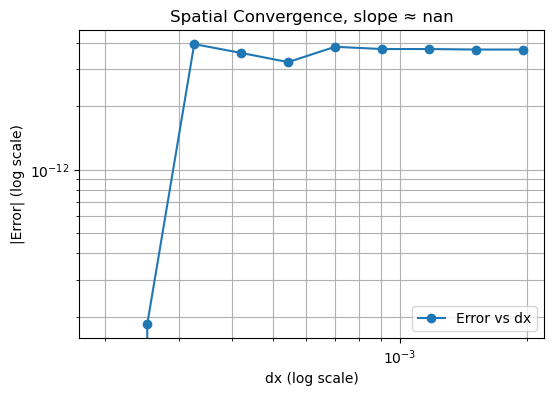

/var/folders/3z/8v47kytj0fd6f702ql2myvk40000gn/T/ipykernel_34835/3866148462.py:25: RuntimeWarning: divide by zero encountered in log
  slope_dt = np.polyfit(np.log(dt_vals), np.log(err_dt),1)[0]


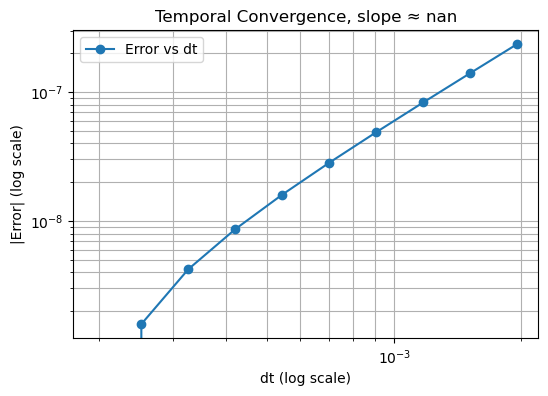

Slopes are irregular.


In [3]:
# ---------------- Part 4: FIX dt, VARY dx  ----------------
dx_vals = np.logspace(np.log10(dx_min), np.log10(dx_min*10), num=10)[::-1]
px_dx = []
for dx in dx_vals:
    px_dx.append(price_once(dx,dt_min,bond_data))
err_dx = np.abs(np.array(px_dx)-P_exact)
plt.figure(figsize=(6,4))
plt.loglog(dx_vals, err_dx, 'o-', label="Error vs dx")
slope_dx = np.polyfit(np.log(dx_vals), np.log(err_dx),1)[0]
plt.xlabel("dx (log scale)")
plt.ylabel("|Error| (log scale)")
plt.title(f"Spatial Convergence, slope ≈ {slope_dx:.2f}")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ---------------- Part 5: FIX dx, VARY dt  ----------------
dt_vals = np.logspace(np.log10(dt_min), np.log10(dt_min*10), num=10)[::-1]
px_dt = []
for dt in dt_vals:
    px_dt.append(price_once(dx_min,dt,bond_data))
err_dt = np.abs(np.array(px_dt)-P_exact)
plt.figure(figsize=(6,4))
plt.loglog(dt_vals, err_dt,'o-', label="Error vs dt")
slope_dt = np.polyfit(np.log(dt_vals), np.log(err_dt),1)[0]
plt.xlabel("dt (log scale)")
plt.ylabel("|Error| (log scale)")
plt.title(f"Temporal Convergence, slope ≈ {slope_dt:.2f}")
plt.grid(True, which="both")
plt.legend()
plt.show()
if abs(slope_dx-2)<0.3 and abs(slope_dt-2)<0.3:
    print("O(dx²)+O(dt²) => dt ~ c·dx")
elif abs(slope_dx-2)<0.3 and abs(slope_dt-1)<0.3:
    print("O(dx²)+O(dt) => dt ~ c·dx²")
else:
    print("Slopes are irregular.")

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit

# ------------------------- Part 1: LOAD DATA -------------------------
def load_data(fp):
    df = pd.read_csv(fp)
    df = df.rename(columns={
        "bond_price": "Pr",
        "BestIVOL": "IVOL",
        "stock_price": "S",
        "CDS": "CDS",
        "coupon_rate": "cp",
        "coupon_frequency": "cfq",
        "conversion_price": "cv",
        "dividend": "d",
        "interest_rate": "r"
    })
    df["T"] = df["ttm_days"] / 365.0
    df["MoneynessRatio"] = df["S"] / df["cv"]
    return df
# --------------------- Part 2: PICK OTM ROW ---------------------
# Define OTM as bonds with moneyness ratio between 0.8 and 1.0.
df = load_data("/Users/calvinxiang/Downloads/synthetic_4M_total.csv")
otm = df[(df["MoneynessRatio"] >= 0.8) & (df["MoneynessRatio"] <= 1.0)]
print("Moneyness Ratio Summary:")
print(df["MoneynessRatio"].describe())
print(f"Number of OTM rows: {len(otm)}")
if len(otm) == 0:
    raise Exception("No OTM rows found with the current threshold.")
selected = otm.iloc[0]
print("Selected OTM row:")
print(selected[['Pr','S','cv','MoneynessRatio']])
bond_data = dict(
    Pr = float(selected["Pr"]),
    T = float(selected["T"]),
    sigma = float(selected["IVOL"]) / 100.0,
    r = float(selected["r"]),
    d = float(selected["d"]),
    rc = float(selected["CDS"]) / 10000.0,
    cv = float(selected["cv"]),
    cp = float(selected["cp"]),
    cfq = int(selected["cfq"]),
    tfc = float(selected["tfc"]),
    S = float(selected["S"])
)



Moneyness Ratio Summary:
count    4.000000e+06
mean     8.448132e-01
std      8.352704e-01
min      5.728112e-02
25%      3.400050e-01
50%      5.788422e-01
75%      1.002284e+00
max      6.661873e+00
Name: MoneynessRatio, dtype: float64
Number of OTM rows: 341326
Selected OTM row:
Pr                71.359319
S                 27.936372
cv                30.516992
MoneynessRatio     0.915437
Name: 17, dtype: float64


In [5]:
tol = 1e-8
dx0, dt0 = 0.1, 0.1
price_list = []
for k in range(10):
    print("current iteration:", k)
    p_new = price_once(dx0, dt0, bond_data)
    print("value at iteration", k, '=', p_new, '\n')
    price_list.append((dx0, dt0, p_new))
    if k > 0:
        p_old = price_list[-2][2]
        diff = abs(p_new - p_old)
        if diff < tol:
            break
    dx0 /= 2
    dt0 /= 2
P_exact = price_list[-1][2]
dx_min, dt_min = price_list[-1][0], price_list[-1][1]
print(dx_min, dt_min)

current iteration: 0
value at iteration 0 = 71.94263150999922 

current iteration: 1
value at iteration 1 = 71.58393212652255 

current iteration: 2
value at iteration 2 = 71.51057940216268 

current iteration: 3
value at iteration 3 = 71.39912832484109 

current iteration: 4
value at iteration 4 = 71.3628009520066 

current iteration: 5
value at iteration 5 = 71.35955030508579 

current iteration: 6
value at iteration 6 = 71.35932372837416 

current iteration: 7
value at iteration 7 = 71.35931855757892 

current iteration: 8
value at iteration 8 = 71.35931857014863 

current iteration: 9
value at iteration 9 = 71.35931858002265 

0.0001953125 0.0001953125


/var/folders/3z/8v47kytj0fd6f702ql2myvk40000gn/T/ipykernel_48321/3186108357.py:9: RuntimeWarning: divide by zero encountered in log
  slope_dx = np.polyfit(np.log(dx_vals), np.log(err_dx), 1)[0]


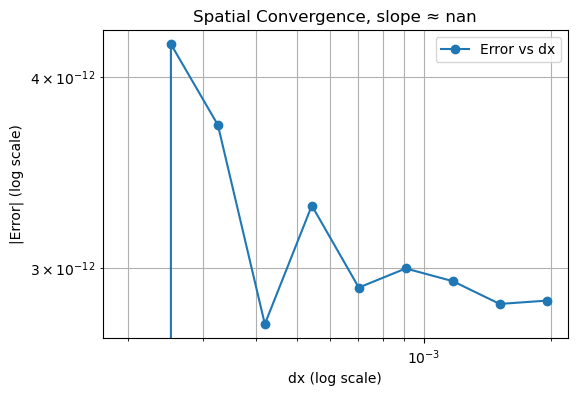

/var/folders/3z/8v47kytj0fd6f702ql2myvk40000gn/T/ipykernel_48321/3186108357.py:25: RuntimeWarning: divide by zero encountered in log
  slope_dt = np.polyfit(np.log(dt_vals), np.log(err_dt), 1)[0]


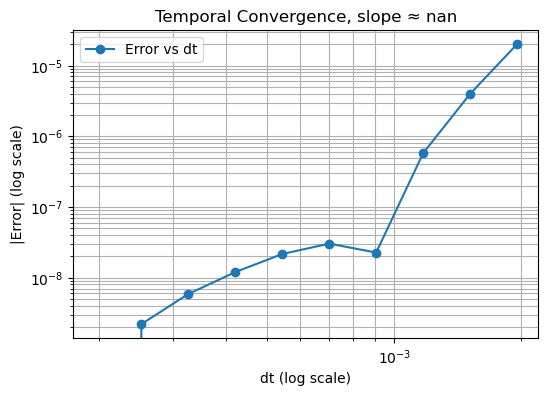

Slopes are irregular.


In [6]:
# ---------------- Part 4: FIX dt, VARY dx ----------------
dx_vals = np.logspace(np.log10(dx_min), np.log10(dx_min * 10), num=10)[::-1]
px_dx = []
for dx in dx_vals:
    px_dx.append(price_once(dx, dt_min, bond_data))
err_dx = np.abs(np.array(px_dx) - P_exact)
plt.figure(figsize=(6, 4))
plt.loglog(dx_vals, err_dx, "o-", label="Error vs dx")
slope_dx = np.polyfit(np.log(dx_vals), np.log(err_dx), 1)[0]
plt.xlabel("dx (log scale)")
plt.ylabel("|Error| (log scale)")
plt.title(f"Spatial Convergence, slope ≈ {slope_dx:.2f}")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ---------------- Part 5: FIX dx, VARY dt ----------------
dt_vals = np.logspace(np.log10(dt_min), np.log10(dt_min * 10), num=10)[::-1]
px_dt = []
for dt in dt_vals:
    px_dt.append(price_once(dx_min, dt, bond_data))
err_dt = np.abs(np.array(px_dt) - P_exact)
plt.figure(figsize=(6, 4))
plt.loglog(dt_vals, err_dt, "o-", label="Error vs dt")
slope_dt = np.polyfit(np.log(dt_vals), np.log(err_dt), 1)[0]
plt.xlabel("dt (log scale)")
plt.ylabel("|Error| (log scale)")
plt.title(f"Temporal Convergence, slope ≈ {slope_dt:.2f}")
plt.grid(True, which="both")
plt.legend()
plt.show()

if abs(slope_dx - 2) < 0.3 and abs(slope_dt - 2) < 0.3:
    print("O(dx²)+O(dt²) => dt ~ c·dx")
elif abs(slope_dx - 2) < 0.3 and abs(slope_dt - 1) < 0.3:
    print("O(dx²)+O(dt) => dt ~ c·dx²")
else:
    print("Slopes are irregular.")

Moneyness Ratio Summary:
count    4.000000e+06
mean     8.448132e-01
std      8.352704e-01
min      5.728112e-02
25%      3.400050e-01
50%      5.788422e-01
75%      1.002284e+00
max      6.661873e+00
Name: MoneynessRatio, dtype: float64
Number of Deep-ITM rows: 778461
Selected Deep-ITM row:
Pr                110.037996
S                  48.935762
cv                 21.334041
MoneynessRatio      2.293788
Name: 8, dtype: float64
current iteration: 0
value at iteration 0 = 220.07599227142896 

current iteration: 1
value at iteration 1 = 220.07599227142904 

dx_min = 0.05 dt_min = 0.05


/var/folders/3z/8v47kytj0fd6f702ql2myvk40000gn/T/ipykernel_52904/4285389946.py:78: RuntimeWarning: divide by zero encountered in log
  slope_dx = np.polyfit(np.log(dx_vals), np.log(err_dx), 1)[0]


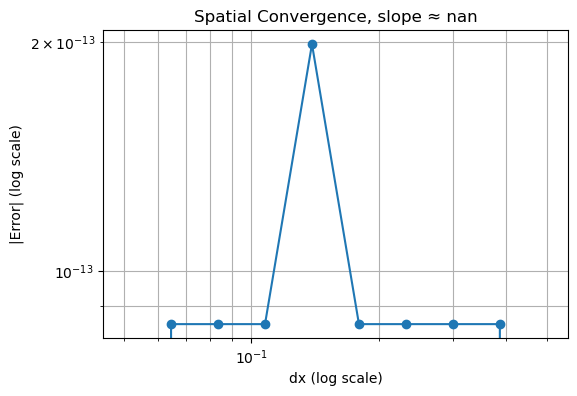

220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904
220.07599227142904


/var/folders/3z/8v47kytj0fd6f702ql2myvk40000gn/T/ipykernel_52904/4285389946.py:93: RuntimeWarning: divide by zero encountered in log
  slope_dt = np.polyfit(np.log(dt_vals), np.log(err_dt), 1)[0]
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


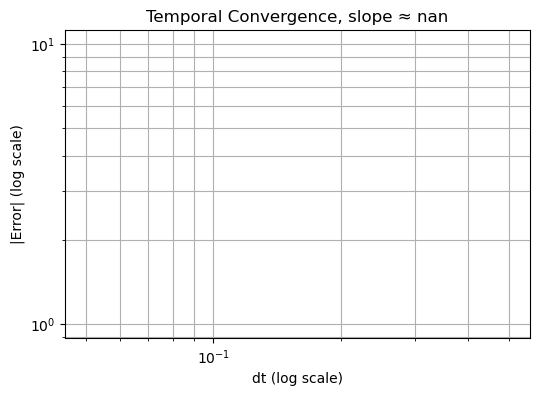

Slopes are irregular.


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit

# ------------------------- Part 1: LOAD DATA -------------------------
def load_data(fp):
    df = pd.read_csv(fp)
    df = df.rename(columns={
        "bond_price": "Pr",
        "BestIVOL": "IVOL",
        "stock_price": "S",
        "CDS": "CDS",
        "coupon_rate": "cp",
        "coupon_frequency": "cfq",
        "conversion_price": "cv",
        "dividend": "d",
        "interest_rate": "r"
    })
    df["T"] = df["ttm_days"] / 365.0
    df["MoneynessRatio"] = df["S"] / df["cv"]
    return df

# --------------------- Part 2: PICK DEEP-ITM ROW ---------------------
# We'll define Deep ITM as MoneynessRatio > 1.2
df = load_data("/Users/calvinxiang/Downloads/synthetic_4M_total.csv")
deep_itm = df[df["MoneynessRatio"] > 1.2]
print("Moneyness Ratio Summary:")
print(df["MoneynessRatio"].describe())
print(f"Number of Deep-ITM rows: {len(deep_itm)}")
if len(deep_itm) == 0:
    raise Exception("No Deep-ITM rows found with the current threshold.")
selected = deep_itm.iloc[1]
print("Selected Deep-ITM row:")
print(selected[["Pr","S","cv","MoneynessRatio"]])
bond_data = dict(
    Pr    = float(selected["Pr"]),
    T     = float(selected["T"]),
    sigma = float(selected["IVOL"]) / 100.0,
    r     = float(selected["r"]),
    d     = float(selected["d"]),
    rc    = float(selected["CDS"]) / 10000.0,
    cv    = float(selected["cv"]),
    cp    = float(selected["cp"]),
    cfq   = int(selected["cfq"]),
    tfc   = float(selected["tfc"]),
    S     = float(selected["S"])
)


tol = 1e-8
dx0, dt0 = 0.1, 0.1
price_list = []
for k in range(20):
    print("current iteration:", k)
    p_new = price_once(dx0, dt0, bond_data)
    print("value at iteration", k, '=', p_new, '\n')
    price_list.append((dx0, dt0, p_new))
    if k>0:
        p_old = price_list[-2][2]
        diff = abs(p_new - p_old)
        if diff < tol:
            break
    dx0 /= 2
    dt0 /= 2
P_exact = price_list[-1][2]
dx_min, dt_min = price_list[-1][0], price_list[-1][1]
print("dx_min =", dx_min, "dt_min =", dt_min)

dx_vals = np.logspace(np.log10(dx_min), np.log10(dx_min*10), num=10)[::-1]
px_dx = []
for dx in dx_vals:
    px_dx.append(price_once(dx, dt_min, bond_data))
err_dx = np.abs(np.array(px_dx) - P_exact)
plt.figure(figsize=(6,4))
plt.loglog(dx_vals, err_dx, 'o-')
slope_dx = np.polyfit(np.log(dx_vals), np.log(err_dx), 1)[0]
plt.xlabel("dx (log scale)")
plt.ylabel("|Error| (log scale)")
plt.title(f"Spatial Convergence, slope ≈ {slope_dx:.2f}")
plt.grid(True, which="both")
plt.show()

dt_vals = np.logspace(np.log10(dt_min), np.log10(dt_min*10), num=10)[::-1]
px_dt = []
for dt in dt_vals:
    print(price_once(dx_min, dt, bond_data))
    px_dt.append(price_once(dx_min, dt, bond_data))
err_dt = np.abs(np.array(px_dt) - P_exact)
plt.figure(figsize=(6,4))
plt.loglog(dt_vals, err_dt, 'o-')
slope_dt = np.polyfit(np.log(dt_vals), np.log(err_dt), 1)[0]
plt.xlabel("dt (log scale)")
plt.ylabel("|Error| (log scale)")
plt.title(f"Temporal Convergence, slope ≈ {slope_dt:.2f}")
plt.grid(True, which="both")
plt.show()

if abs(slope_dx - 2)<0.3 and abs(slope_dt - 2)<0.3:
    print("O(dx²)+O(dt²) => dt ~ c·dx")
elif abs(slope_dx - 2)<0.3 and abs(slope_dt - 1)<0.3:
    print("O(dx²)+O(dt) => dt ~ c·dx²")
else:
    print("Slopes are irregular.")

